In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
num_features = 20
# generate regression dataset
X, y = make_regression(n_samples=4000, n_features=num_features, noise=0.1, random_state=1)

# split into train and test
n_train = 2000
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# reshape 1d arrays to 2d arrays
trainy = trainy.reshape(len(trainy), 1)
testy = testy.reshape(len(trainy), 1)

# create scaler
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(trainy)
# transform training dataset
trainy = scaler.transform(trainy)
# transform test dataset
testy = scaler.transform(testy)

# fit scaler on training dataset
scaler.fit(trainX)
# transform training dataset
trainX = scaler.transform(trainX)
# transform test dataset
testX = scaler.transform(testX)

In [3]:
df = pd.DataFrame(trainy, columns=['y'])
df['lab']=np.where(df.y.shift(-1)>df.y,1,0) #like price prediction
trainy=df.lab.fillna(0).values
df = pd.DataFrame(testy, columns=['y'])
df['lab']=np.where(df.y.shift(-1)>df.y,1,0) #like price prediction
testy=df.lab.fillna(0).values

In [4]:
# SVM classifier with scaled inputs outputs on the regression problem

def create_model(optimizer='adam'):
    # define model (see links at the bottom)
    model = Sequential()
    model.add(Dense(input_dim=20, units=64, activation='relu'))
    model.add(Dense(units=1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    #compile the model
    model.compile(loss='hinge', optimizer=optimizer, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=1)

# define the grid search hyper parameter options and dictionary
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

#create the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(trainX, trainy)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Epoch 1/100
2000/2000 [==============================] - 0s 86us/step - loss: 0.7468 - acc: 0.4730
Epoch 2/100
2000/2000 [==============================] - 0s 25us/step - loss: 0.5258 - acc: 0.2225
Epoch 3/100
2000/2000 [==============================] - 0s 25us/step - loss: 0.5158 - acc: 0.1710
Epoch 4/100
2000/2000 [==============================] - 0s 24us/step - loss: 0.5101 - acc: 0.2450
Epoch 5/100
2000/2000 [==============================] - 0s 25us/step - loss: 0.5065 - acc: 0.3085
Epoch 6/100
2000/2000 [==============================] - 0s 26us/step - loss: 0.5046 - acc: 0.3575
Epoch 7/100
2000/2000 [==============================] - 0s 26us/step - loss: 0.5035 - acc: 0.3770
Epoch 8/100
2000/2000 [==============================] - 0s 26us/step - loss: 0.5029 - acc: 0.3810
Epoch 9/100
2000/2000 [==============================] - 0s 25us/step - loss: 0.5025 - acc: 0.4115
Epoch 10/100
2000/2000 [==============================] - 0s 25us/step - loss: 0.5022 - acc: 0.4295
Epoch 11/

Redefine the model using the best optimizer from above

Train on 2000 samples, validate on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 0s 108us/step - loss: 0.6969 - acc: 0.4260 - val_loss: 0.5474 - val_acc: 0.2645
Epoch 2/100
2000/2000 [==============================] - 0s 32us/step - loss: 0.5262 - acc: 0.1700 - val_loss: 0.5267 - val_acc: 0.1135
Epoch 3/100
2000/2000 [==============================] - 0s 34us/step - loss: 0.5165 - acc: 0.1425 - val_loss: 0.5196 - val_acc: 0.1505
Epoch 4/100
2000/2000 [==============================] - 0s 34us/step - loss: 0.5106 - acc: 0.2005 - val_loss: 0.5148 - val_acc: 0.2205
Epoch 5/100
2000/2000 [==============================] - 0s 35us/step - loss: 0.5068 - acc: 0.2625 - val_loss: 0.5119 - val_acc: 0.2695
Epoch 6/100
2000/2000 [==============================] - 0s 35us/step - loss: 0.5047 - acc: 0.2955 - val_loss: 0.5104 - val_acc: 0.3000
Epoch 7/100
2000/2000 [==============================] - 0s 35us/step - loss: 0.5035 - acc: 0.3150 - val_loss: 0.5095 - val_acc: 0.3335

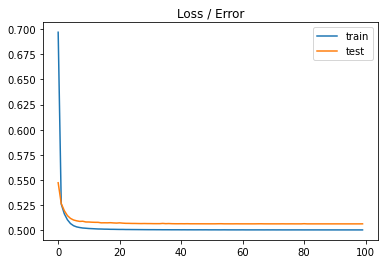

In [5]:
# define model
model = Sequential()
model.add(Dense(input_dim=20, units=64, activation='relu'))
model.add(Dense(units=1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=0.01)))
#compile the model
model.compile(loss='hinge', optimizer=grid_result.best_params_['optimizer'], metrics=['accuracy'])
#fit the model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_e = model.evaluate(trainX, trainy, verbose=1)
test_e = model.evaluate(testX, testy, verbose=1)
print('Train loss: %.3f, Test loss: %.3f' % (train_e[0], test_e[0])) 
print('Train metric: %.3f, Test metric: %.3f' % (train_e[1], test_e[1])) 
#plot loss during training
plt.title('Loss / Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

References:
https://archive.md/sanjs
https://archive.md/lOvhL

Can you program a simple tree with Keras Tensorflow? Keras layers do not include preprogrammed tree layers. Instead, Keras Tensforflow website includes tree and random forest models: https://archive.md/aic4b